## Monte Carlo Markov Chain

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt


# ------------------------------------------------------
#                  PARAMETERS (User Editable)
# ------------------------------------------------------
SEED = 123
N_SAMPLES = 30000       # total iterations
BURN_IN = 5000          # burn-in
SIGMA_PROPOSAL = 1.0    # proposal Normal(0, sigma^2)
X0 = 20                 # start far from target to show convergence

In [ ]:

# ------------------------------------------------------
#          1. Linear Congruential Generator (LCG)
# ------------------------------------------------------
def lcg(seed):
    """
    Simple LCG using Park-Miller values.
    Each call updates seed and returns a U(0,1) random number.
    """
    a = 16807
    m = 2**31 - 1
    seed = (a * seed) % m
    return seed, seed / m


# ------------------------------------------------------
#          2. Box-Muller to generate N(0, sigma^2)
# ------------------------------------------------------
def box_muller(seed, sigma=1.0):
    """
    Given an LCG seed, return:
    - updated seed
    - one Normal(0, sigma^2) random variable
    """
    seed, u1 = lcg(seed)
    seed, u2 = lcg(seed)

    # Avoid log(0)
    if u1 <= 0:
        u1 = 1e-12

    z = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
    return seed, sigma * z

# ------------------------------------------------------
#         3. TARGET DISTRIBUTION (N(0,1) here)
# ------------------------------------------------------
def target_pdf(x):
    """
    Standard normal pdf. Easy to replace with your own target.
    """
    return (1 / math.sqrt(2 * math.pi)) * math.exp(-0.5 * x * x)


In [3]:
# ------------------------------------------------------
#         4. Metropolis–Hastings MCMC
# ------------------------------------------------------
def mcmc(seed, n_samples, burn_in, sigma_prop, x0):
    samples = np.zeros(n_samples)
    x = x0
    accepted = 0

    for i in range(n_samples):
        # Generate proposal: x_new = x_old + Normal(0, sigma_prop^2)
        seed, noise = box_muller(seed, sigma=sigma_prop)
        proposal = x + noise

        # Compute acceptance ratio alpha
        t_old = target_pdf(x)
        t_new = target_pdf(proposal)

        # Avoid division by zero
        if t_old == 0:
            alpha = 1 if t_new > 0 else 0
        else:
            alpha = t_new / t_old

        # Draw U(0,1) from LCG
        seed, u = lcg(seed)

        # Accept or reject
        if u < min(1, alpha):
            x = proposal
            accepted += 1

        samples[i] = x

    acc_rate = accepted / n_samples
    return samples, acc_rate

Acceptance Rate = 0.7035666666666667
Post burn-in mean = -0.011508349453377281
Post burn-in std  = 0.9943733650502963


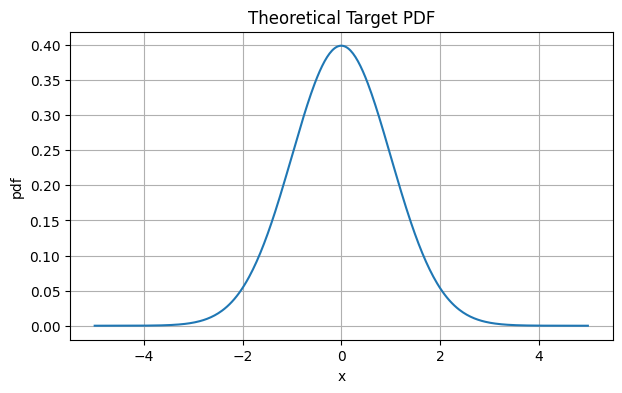

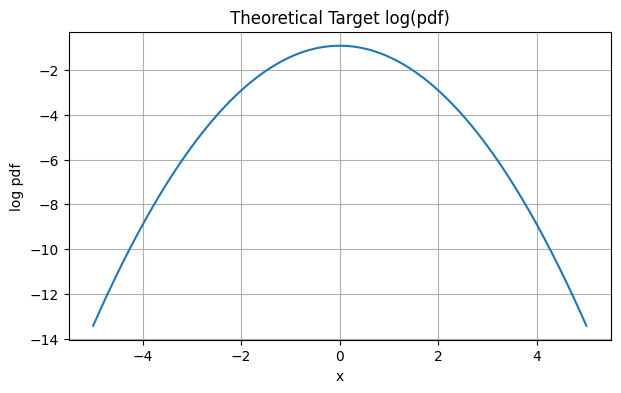

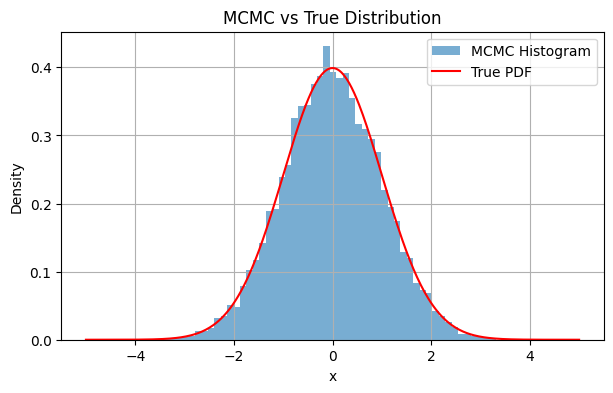

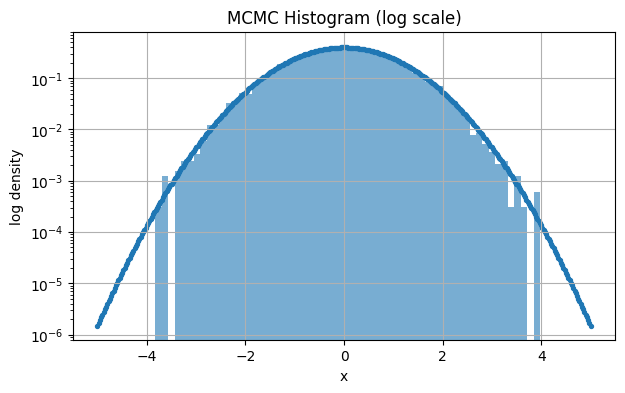

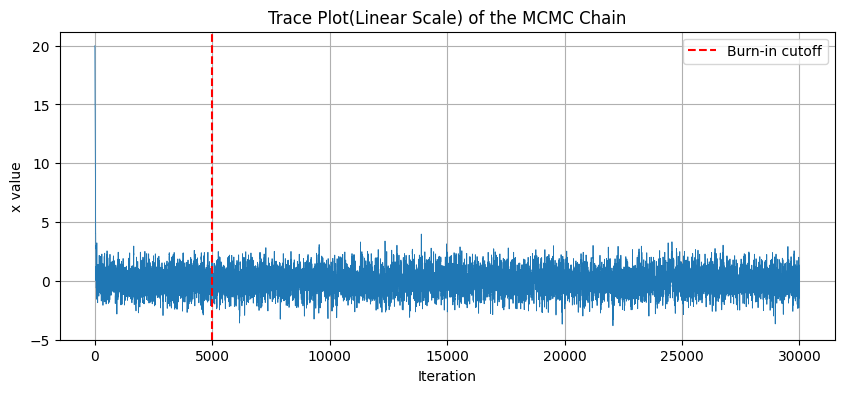

In [4]:
# ------------------------------------------------------
#                  RUN MCMC
# ------------------------------------------------------
samples, acc_rate = mcmc(SEED, N_SAMPLES, BURN_IN, SIGMA_PROPOSAL, X0)
post_samples = samples[BURN_IN:]

print("Acceptance Rate =", acc_rate)
print("Post burn-in mean =", np.mean(post_samples))
print("Post burn-in std  =", np.std(post_samples))


# ------------------------------------------------------
#                  5. PLOTS
# ------------------------------------------------------
xs = np.linspace(-5, 5, 400)
pdf_vals = np.array([target_pdf(x) for x in xs])

# (i) Theoretical target (linear scale)
plt.figure(figsize=(7,4))
plt.plot(xs, pdf_vals)
plt.title("Theoretical Target PDF")
plt.xlabel("x")
plt.ylabel("pdf")
plt.grid()
plt.show()

# (i-b) Theoretical target (log scale)
plt.figure(figsize=(7,4))
plt.plot(xs, np.log(pdf_vals))
plt.title("Theoretical Target log(pdf)")
plt.xlabel("x")
plt.ylabel("log pdf")
plt.grid()
plt.show()

# (ii) MCMC histogram (linear)
plt.figure(figsize=(7,4))
plt.hist(post_samples, bins=60, density=True, alpha=0.6, label="MCMC Histogram")
plt.plot(xs, pdf_vals, 'r-', label="True PDF")
plt.title("MCMC vs True Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

# (ii-b) MCMC histogram (log scale)
plt.figure(figsize=(7,4))
plt.hist(post_samples, bins=60, density=True, alpha=0.6, log=True)
plt.scatter(xs, pdf_vals, s=8)
plt.title("MCMC Histogram (log scale)")
plt.xlabel("x")
plt.ylabel("log density")
plt.grid()
plt.show()

# (iii) Trace plot(linear scale)
plt.figure(figsize=(10,4))
plt.plot(samples, linewidth=0.6)
plt.axvline(BURN_IN, color='red', linestyle='--', label="Burn-in cutoff")
plt.title("Trace Plot(Linear Scale) of the MCMC Chain")
plt.xlabel("Iteration")
plt.ylabel("x value")
plt.legend()
plt.grid()
plt.show()
